# Part-2 : Correlation, VIF, PCA, and Dimensionality Reduction

This notebook combines the full analysis pipeline for two datasets:
- `patient-data.csv`
- `curse-of-dimensionality.xlsx` (all sheets will be processed)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Sklearn imports for Modeling and Evaluation
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    r2_score, mean_absolute_error, mean_squared_error
)
from sklearn.decomposition import PCA

# Statsmodels for VIF Analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

## Helper functions
These helpers compute VIF, run a model and evaluate metrics for both regression and classification. Plots after performing PCA and iterative VIF, different techniques to check, final determination during analysis on which technique to proceed with

In [2]:
# --- 1. Learning Curve (Impact of Sample Size) ---
def plot_learning_curve(model, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy', title=''):
    try:
        train_sizes_abs, train_scores, test_scores = learning_curve(
            model, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes, scoring=scoring
        )
        train_mean = np.mean(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)

        plt.figure(figsize=(8, 5))
        plt.title(f"Impact of Sample Size on {scoring.title()}\n({title})")
        plt.xlabel("Training examples")
        plt.ylabel(f"Score ({scoring})")
        plt.grid(True)
        plt.plot(train_sizes_abs, train_mean, 'o-', color="r", label="Training score")
        plt.plot(train_sizes_abs, test_mean, 'o-', color="g", label="Cross-validation score")
        plt.legend(loc="best")
        plt.show()
    except Exception as e:
        print(f"Could not plot learning curve: {e}")

# --- 2. Correlation Heatmap ---
def plot_correlation_heatmap(df, title=''):
    plt.figure(figsize=(10, 8))
    # Drop non-numeric columns for correlation
    numeric_df = df.select_dtypes(include=[np.number])
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", annot_kws={"size": 8})
    plt.title(f"Correlation Heatmap ({title})")
    plt.show()

# --- 3. VIF Calculation ---
def get_vif(X):
    # Add constant to calculate VIF correctly (statsmodels requirement)
    X_const = add_constant(X)
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_const.columns
    vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
    
    # Return VIF excluding the constant term
    return vif_data[vif_data["Feature"] != "const"].sort_values(by="VIF", ascending=False)

# --- 4. Plot VIF Elimination Trend ---
def plot_vif_trend(metrics_log, title=''):
    log_df = pd.DataFrame(metrics_log)
    plt.figure(figsize=(10, 6))
    for metric in log_df.columns:
        if metric != 'features_remaining':
            plt.plot(log_df['features_remaining'], log_df[metric], marker='o', label=metric)
    plt.xlabel("Number of Features Remaining")
    plt.ylabel("Metric Score")
    plt.title(f"Model Performance vs. VIF Elimination ({title})")
    plt.legend()
    plt.gca().invert_xaxis() # Show x-axis going from High -> Low features
    plt.grid(True)
    plt.show()

# --- 5. PCA Explained Variance Plot ---
def plot_pca_variance(pca, title=''):
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    n_components = len(explained_variance)
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, n_components + 1), explained_variance, alpha=0.8, align='center', label='Individual Variance')
    plt.step(range(1, n_components + 1), cumulative_variance, where='mid', label='Cumulative Variance', color='red')
    plt.ylabel('Explained Variance Ratio')
    plt.xlabel('Principal Component')
    plt.title(f"PCA Explained Variance ({title})")
    plt.xticks(range(1, n_components + 1))
    plt.legend(loc='best')
    plt.show()

LOAD DATA

In [3]:
# Load Patient Data
try:
    df_patient = pd.read_csv('patient-data.csv')
    print("Patient Data Loaded. Shape:", df_patient.shape)
except FileNotFoundError:
    print("Error: 'patient-data.csv' not found.")

# Load Curse of Dimensionality Data
try:
    # Load all sheets as a dictionary
    curse_data_sheets = pd.read_excel('curse-of-dimensionality.xlsx', sheet_name=None)
    print("Curse of Dimensionality Data Loaded. Sheets:", list(curse_data_sheets.keys()))
except FileNotFoundError:
    print("Error: 'curse-of-dimensionality.xlsx' not found.")

Patient Data Loaded. Shape: (2371, 25)
Curse of Dimensionality Data Loaded. Sheets: ['Sheet1', 'Sheet2', 'Sheet3']


--- ANALYSIS: PATIENT DATA (Classification) ---
Missing values before cleaning:
p03    1
p04    1
p05    1
p06    1
p07    1
p08    1
p09    1
p10    1
p11    1
p12    1
p13    1
p14    1
p15    2
p16    2
p17    1
p18    1
p19    1
p20    1
p21    1
p22    1
dtype: int64

Data Cleaned & Scaled. Shape: (2371, 24)

[Step 1] Observing Impact of Sample Size...


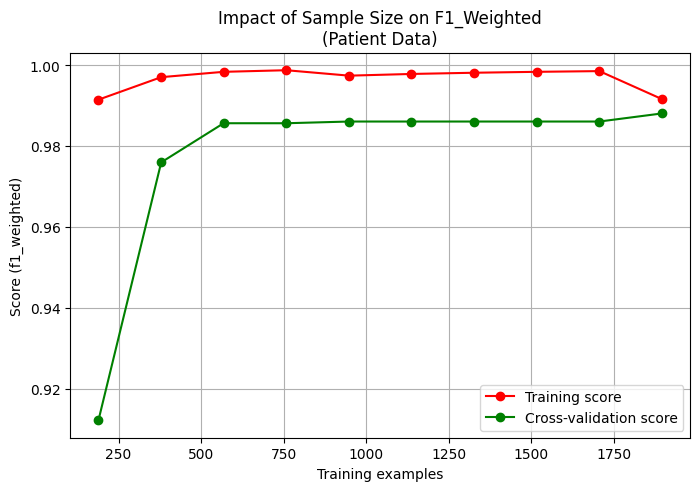

In [4]:
print("--- ANALYSIS: PATIENT DATA (Classification) ---")

# 1. Separate Target and Features
target_col = 'Ailment'
X_raw = df_patient.drop(target_col, axis=1)
y = df_patient[target_col]

# 2. Handle Missing Values (Imputation)
print(f"Missing values before cleaning:\n{X_raw.isnull().sum()[X_raw.isnull().sum() > 0]}")

imputer = SimpleImputer(strategy='mean')
# Only impute numeric columns
X_numeric = X_raw.select_dtypes(include=[np.number])
X_imputed = pd.DataFrame(imputer.fit_transform(X_numeric), columns=X_numeric.columns)

# 3. Scale Features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X_imputed.columns)

# 4. Encode Target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("\nData Cleaned & Scaled. Shape:", X_scaled.shape)

# Step 1: Learning Curve
# We use Logistic Regression for this classification task
print("\n[Step 1] Observing Impact of Sample Size...")
plot_learning_curve(LogisticRegression(max_iter=1000), X_scaled, y_encoded, scoring='f1_weighted', title='Patient Data')

NEED to clean missing values otherwise techniques like logistic regression will not work.


[Step 2] Pair-wise Correlation Analysis...


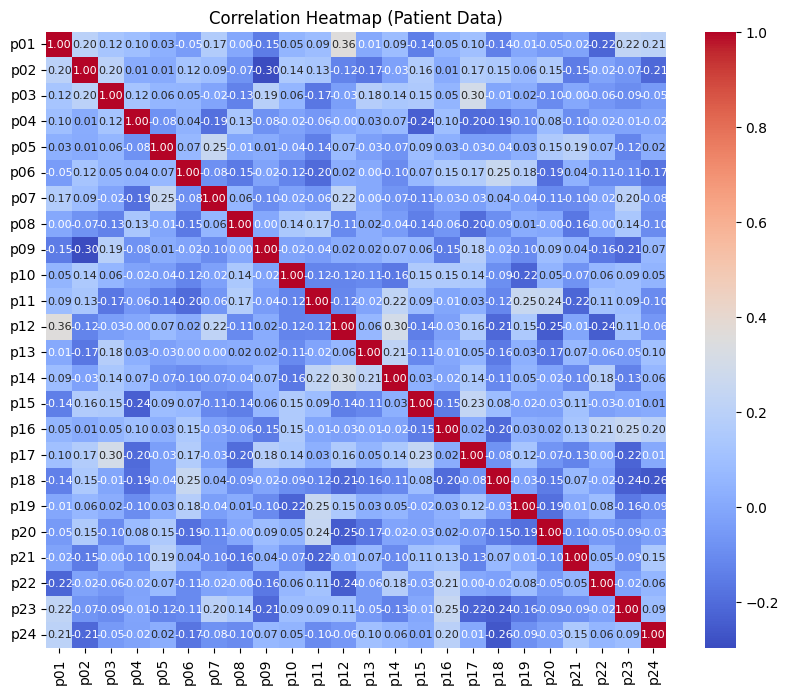

In [5]:
# Step 2: Correlation Heatmap
print("\n[Step 2] Pair-wise Correlation Analysis...")
plot_correlation_heatmap(X_scaled, title='Patient Data')

Indicating data which is not highly correlated, only few/no samples might get dropped from VIF


[Step 3 & 4] VIF Analysis and Progressive Elimination...
Baseline F1-Score (All Features): 0.9811
Max VIF is 2.30 (<= 10). Stopping elimination.


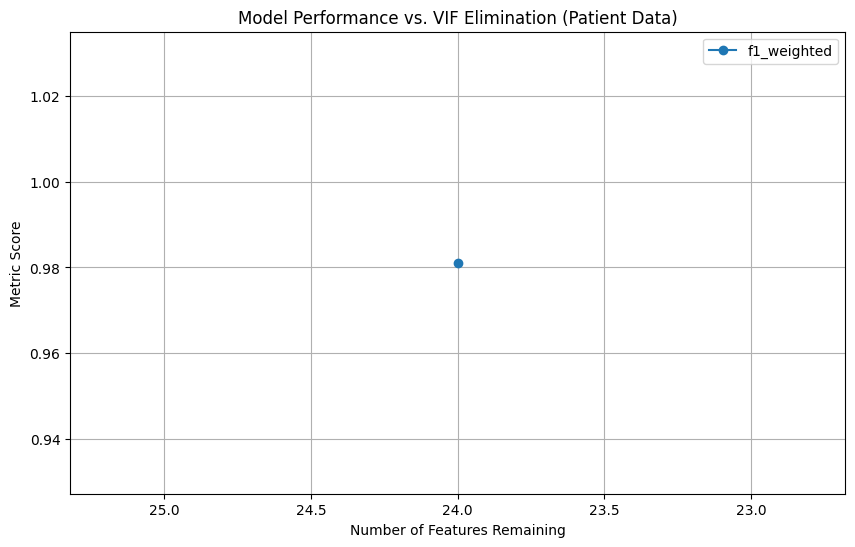

Final features after VIF reduction (24): ['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p07', 'p08', 'p09', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24']


In [6]:
print("\n[Step 3 & 4] VIF Analysis and Progressive Elimination...")

# 1. Establish Baseline
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Verify no NaNs exist before fitting
if np.isnan(X_train).any().any():
    print("Error: NaNs still present in training data!")
else:
    base_model = LogisticRegression(max_iter=1000)
    base_model.fit(X_train, y_train)
    y_pred = base_model.predict(X_test)
    baseline_f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Baseline F1-Score (All Features): {baseline_f1:.4f}")

    # 2. Progressive Elimination Loop
    metrics_log = []
    X_curr = X_scaled.copy()

    # Log initial state
    metrics_log.append({'features_remaining': len(X_curr.columns), 'f1_weighted': baseline_f1})

    while True:
        # Calculate VIF
        vif_data = get_vif(X_curr)
        
        # Check if we should stop (Empty or Max VIF <= 10)
        if vif_data.empty: break
        max_vif = vif_data.iloc[0]['VIF']
        feature_to_drop = vif_data.iloc[0]['Feature']
        
        if max_vif <= 10:
            print(f"Max VIF is {max_vif:.2f} (<= 10). Stopping elimination.")
            break
        
        # Drop the feature
        # print(f"Dropping {feature_to_drop} (VIF={max_vif:.2f})") 
        X_curr = X_curr.drop(columns=[feature_to_drop])
        
        # Retrain and Evaluate
        X_train_v, X_test_v, y_train_v, y_test_v = train_test_split(X_curr, y_encoded, test_size=0.2, random_state=42)
        model_v = LogisticRegression(max_iter=1000)
        model_v.fit(X_train_v, y_train_v)
        y_pred_v = model_v.predict(X_test_v)
        score_v = f1_score(y_test_v, y_pred_v, average='weighted')
        
        metrics_log.append({'features_remaining': len(X_curr.columns), 'f1_weighted': score_v})

    # Plot the trend
    plot_vif_trend(metrics_log, title='Patient Data')
    print(f"Final features after VIF reduction ({len(X_curr.columns)}): {list(X_curr.columns)}")

Since VIF for all features less than 10 (or 5, common threshold values, can choose others), no features dropped


[Step 5] Performing PCA...


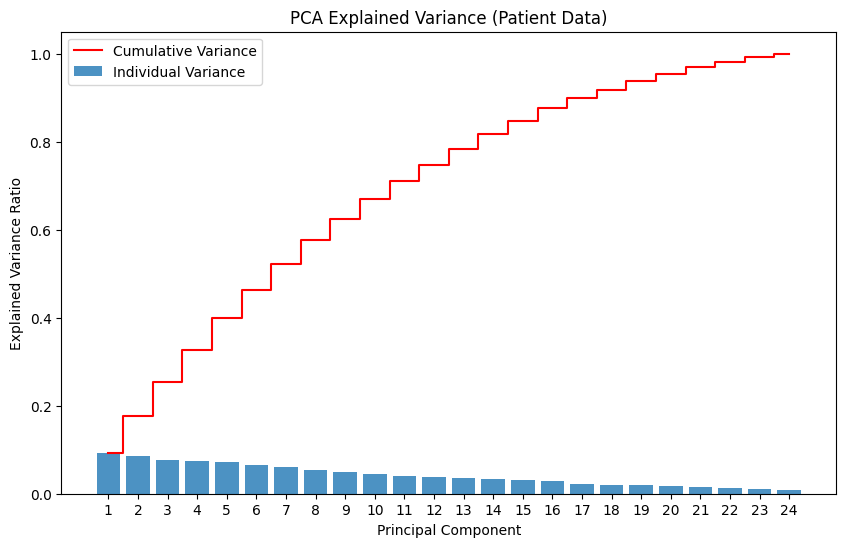

Variance explained by first 3 PCs: 25.36%
Variance explained by first 5 PCs: 39.86%


In [7]:
print("\n[Step 5] Performing PCA...")
pca = PCA()
pca.fit(X_scaled)
plot_pca_variance(pca, title='Patient Data')

# Check variance for top components
print(f"Variance explained by first 3 PCs: {np.sum(pca.explained_variance_ratio_[:3]):.2%}")
print(f"Variance explained by first 5 PCs: {np.sum(pca.explained_variance_ratio_[:5]):.2%}")

ML models with PCA and comparison

In [8]:
print("\n[Step 6] ML Models with PCA Subsets...")

# Transform data
X_pca = pca.transform(X_scaled)
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_pca, y_encoded, test_size=0.2, random_state=42)

results = []

# 1. Original Features (Baseline)
results.append(["Original Features", X_scaled.shape[1], baseline_f1])

# 2. VIF Reduced (from Step 4)
vif_f1 = metrics_log[-1]['f1_weighted']
results.append(["VIF Reduced", metrics_log[-1]['features_remaining'], vif_f1])

# 3. PCA Models (e.g., 3 PCs and 5 PCs)
for n_comp in [3, 5]:
    if n_comp <= X_scaled.shape[1]:
        model_p = LogisticRegression(max_iter=1000)
        model_p.fit(X_train_p[:, :n_comp], y_train_p)
        y_pred_p = model_p.predict(X_test_p[:, :n_comp])
        score_p = f1_score(y_test_p, y_pred_p, average='weighted')
        results.append([f"PCA ({n_comp} Components)", n_comp, score_p])

# Print Comparison Table
print(f"\n{'Model Type':<25} | {'Features':<10} | {'F1-Weighted':<15}")
print("-" * 55)
for res in results:
    print(f"{res[0]:<25} | {res[1]:<10} | {res[2]:.4f}")
print("-" * 55)


[Step 6] ML Models with PCA Subsets...

Model Type                | Features   | F1-Weighted    
-------------------------------------------------------
Original Features         | 24         | 0.9811
VIF Reduced               | 24         | 0.9811
PCA (3 Components)        | 3          | 0.3418
PCA (5 Components)        | 5          | 0.4127
-------------------------------------------------------


FOR curse of dimensionality dataset with all 3 sheets, similar analysis is performed

Performed for logistic regression, can use other classification techniques

In [9]:
def analyze_regression_sheet(df, sheet_name):
    print(f"\n{'='*60}")
    print(f"ANALYSIS: {sheet_name}")
    print(f"{'='*60}")
    
    target_col = 'y'
    if target_col not in df.columns:
        print(f"Target '{target_col}' not found in {sheet_name}. Skipping.")
        return

    X_raw = df.drop(target_col, axis=1)
    y = df[target_col]
    
    # --- IMPUTATION ---
    imputer = SimpleImputer(strategy='mean')
    X_imputed = pd.DataFrame(imputer.fit_transform(X_raw), columns=X_raw.columns)

    # --- SCALING ---
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X_imputed.columns)
    
    # --- Step 1: Learning Curve ---
    plot_learning_curve(LinearRegression(), X_scaled, y, scoring='r2', title=sheet_name)
    
    if X_scaled.shape[1] < 2:
        print("Not enough features for Correlation/VIF/PCA analysis.")
        return

    # --- Step 2: Correlation ---
    plot_correlation_heatmap(X_scaled, title=sheet_name)
    
    # --- Step 3 & 4: VIF ---
    # Baseline
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    baseline_r2 = r2_score(y_test, model.predict(X_test))
    
    # VIF Loop
    X_curr = X_scaled.copy()
    metrics_log = [{'features_remaining': len(X_curr.columns), 'r2': baseline_r2}]
    
    while True:
        vif_data = get_vif(X_curr)
        if vif_data.empty or vif_data.iloc[0]['VIF'] <= 10: break
        
        drop_feat = vif_data.iloc[0]['Feature']
        X_curr = X_curr.drop(columns=[drop_feat])
        
        X_tr, X_te, y_tr, y_te = train_test_split(X_curr, y, test_size=0.2, random_state=42)
        m = LinearRegression()
        m.fit(X_tr, y_tr)
        metrics_log.append({'features_remaining': len(X_curr.columns), 'r2': r2_score(y_te, m.predict(X_te))})
        
    plot_vif_trend(metrics_log, title=sheet_name)
    print(f"Final Features (VIF Reduced): {list(X_curr.columns)}")
    
    # --- Step 5: PCA ---
    pca = PCA()
    pca.fit(X_scaled)
    plot_pca_variance(pca, title=sheet_name)
    
    # --- Step 6: Comparison ---
    X_pca = pca.transform(X_scaled)
    X_tr_p, X_te_p, y_tr_p, y_te_p = train_test_split(X_pca, y, test_size=0.2, random_state=42)
    
    results = [["Original", X_scaled.shape[1], baseline_r2],
               ["VIF Reduced", metrics_log[-1]['features_remaining'], metrics_log[-1]['r2']]]
    
    # Try PCA with 1, 2, 3 components
    for n in [1, 2, 3]:
        if n <= X_scaled.shape[1]:
            m_p = LinearRegression()
            m_p.fit(X_tr_p[:, :n], y_tr_p)
            results.append([f"PCA ({n})", n, r2_score(y_te_p, m_p.predict(X_te_p[:, :n]))])
            
    print(f"\nModel Comparison ({sheet_name}):")
    print(f"{'Model':<15} | {'Feats':<5} | {'R2 Score':<10}")
    for row in results:
        print(f"{row[0]:<15} | {row[1]:<5} | {row[2]:.4f}")


ANALYSIS: Sheet1


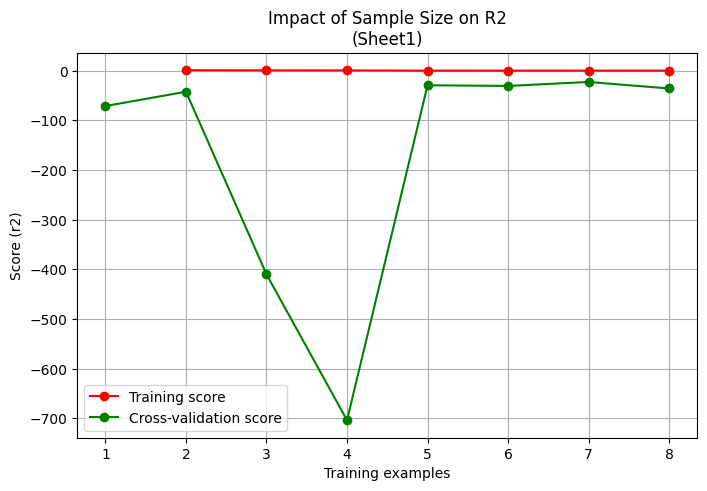

Not enough features for Correlation/VIF/PCA analysis.

ANALYSIS: Sheet2


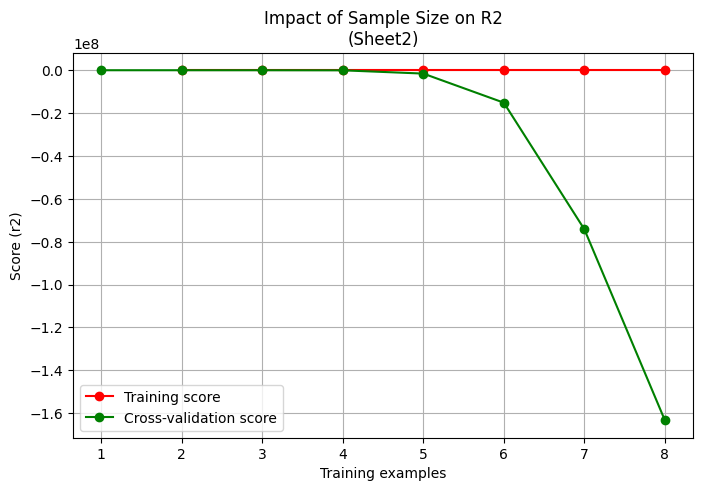

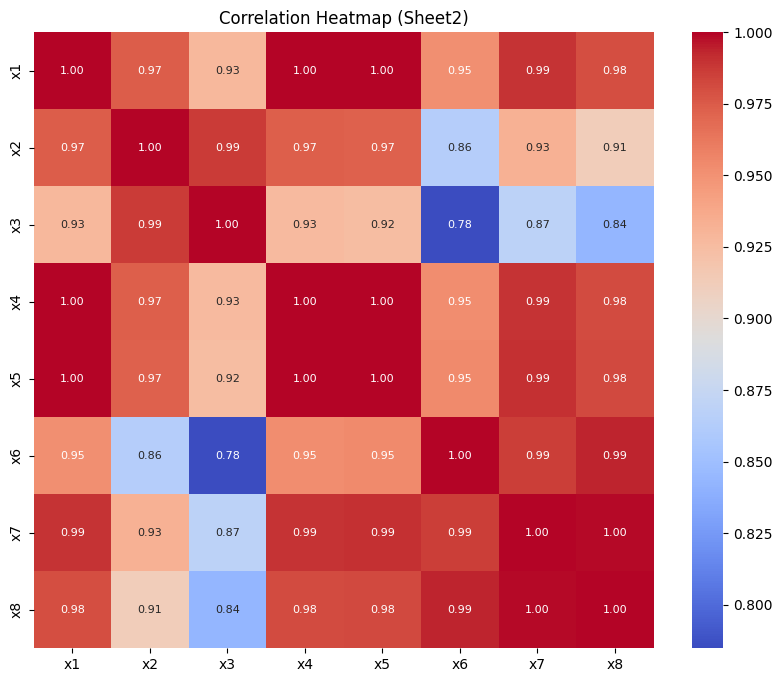

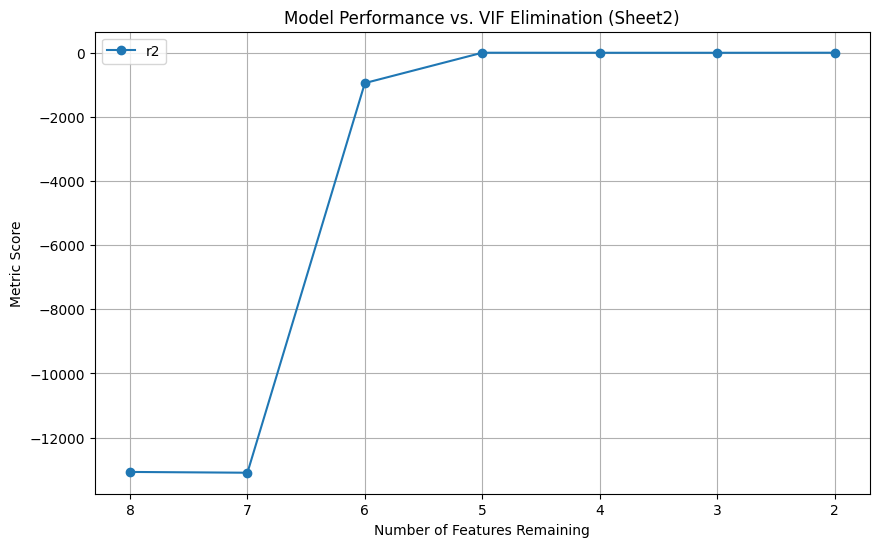

Final Features (VIF Reduced): ['x3', 'x6']


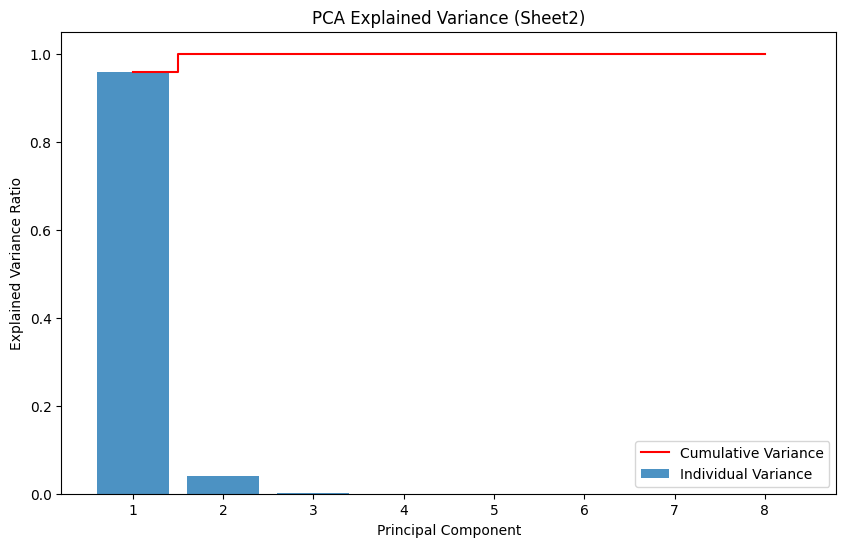


Model Comparison (Sheet2):
Model           | Feats | R2 Score  
Original        | 8     | -13072.6855
VIF Reduced     | 2     | 0.3193
PCA (1)         | 1     | 0.2751
PCA (2)         | 2     | 0.2318
PCA (3)         | 3     | -1.3321

ANALYSIS: Sheet3


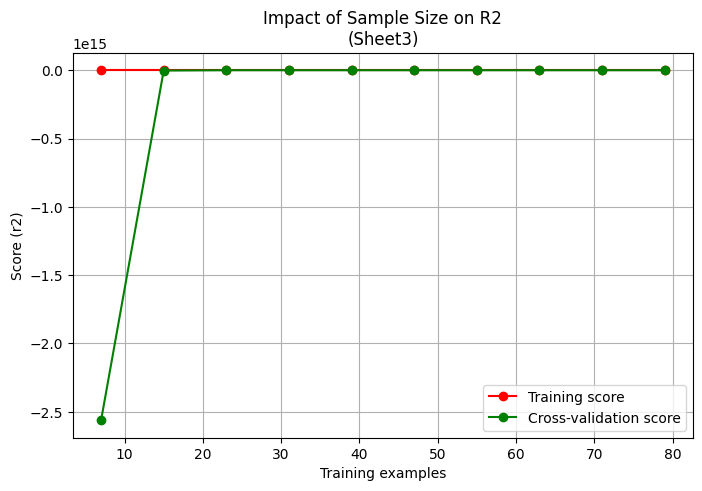

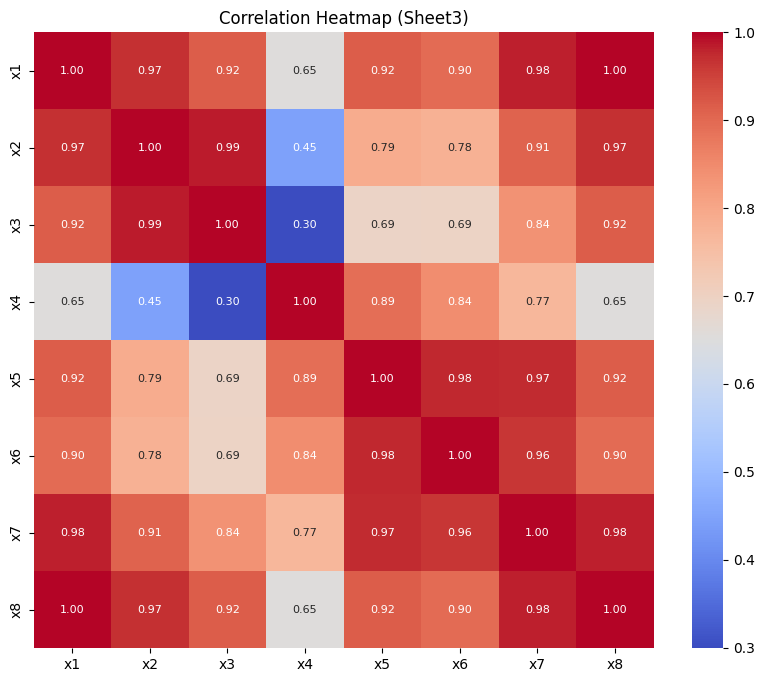

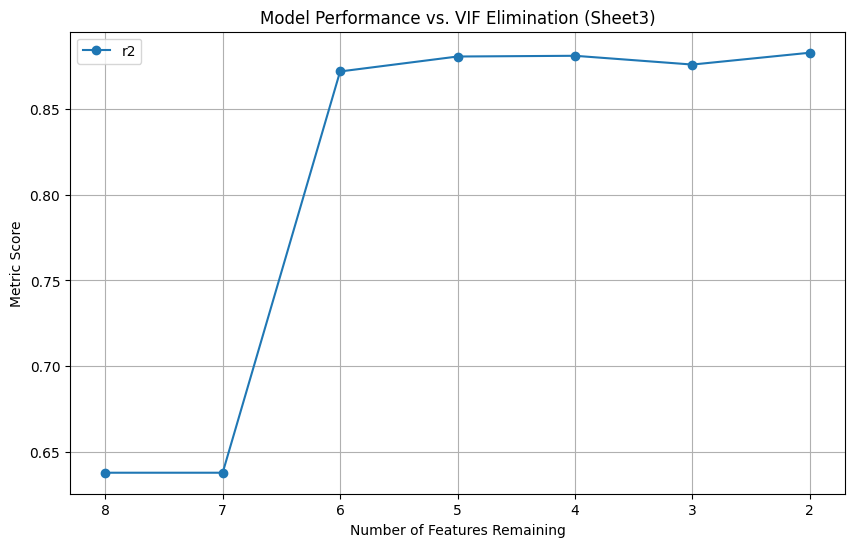

Final Features (VIF Reduced): ['x2', 'x4']


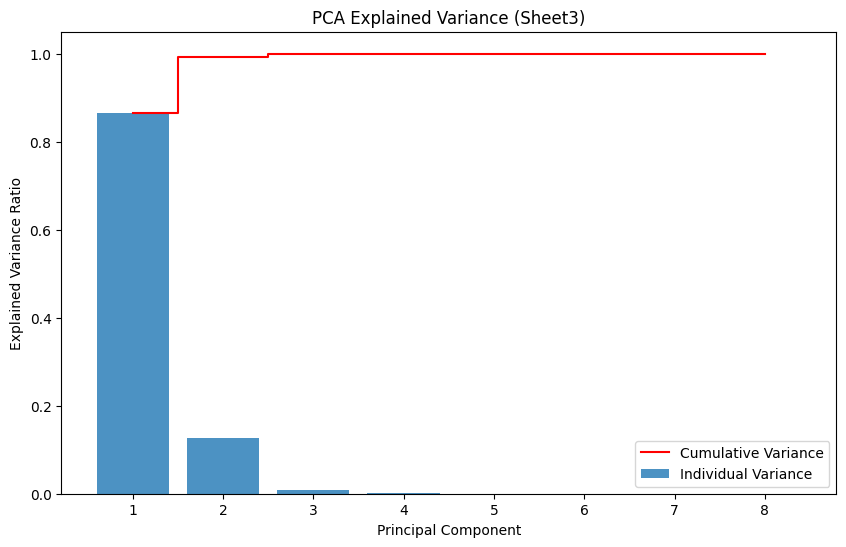


Model Comparison (Sheet3):
Model           | Feats | R2 Score  
Original        | 8     | 0.6379
VIF Reduced     | 2     | 0.8828
PCA (1)         | 1     | 0.8168
PCA (2)         | 2     | 0.8542
PCA (3)         | 3     | 0.8808


In [10]:
# Iterate through each sheet in the curse data and run the analysis
for sheet_name, df_sheet in curse_data_sheets.items():
    analyze_regression_sheet(df_sheet, sheet_name)